In [2]:
import os
import cv2
import torch
import numpy as np
import shutil

In [3]:
os.chdir('E:\car plates code\plates-models-master\model8/')

detection_model =torch.hub.load('.', 'custom', path='E:\car plates code\plates-models-master\detection_model\model2/best.pt', source='local')

recognition_model = torch.hub.load('.', 'custom', path=r'E:\car plates code\plates-models-master\model8\best.pt', source='local')

YOLOv5  2023-9-20 Python-3.9.12 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
YOLOv5  2023-9-20 Python-3.9.12 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7080247 parameters, 0 gradients, 16.0 GFLOPs
Adding AutoShape... 


In [4]:
images = r'E:\car plates code\plates-models-master\images/'
cropped_img_dir = r'E:\car plates code\plates-models-master\model8\runs\detect'
exp_path = r'E:\car plates code\plates-models-master\model8\runs\detect\exp'
saved_img_dir = r'E:\car plates code\plates-models-master\saved_images'
resized_img_dir = r'E:\car plates code\plates-models-master\resized_images'

In [36]:
# def delete_folder_or_file(path):
#     folder_path = path.split("\\")
#     if "exp" in folder_path:
#         shutil.rmtree(path)
#     else:
#         for img in os.listdir(path):
#             img_path = path + "\\" + img
#             # Use os.remove() to delete the file
#             os.remove(img_path)
#     return

In [5]:
def delete_folder_or_file(path):
    try:
        if os.path.exists(path):
            folder_path = path.split("\\")
            if "exp" in folder_path:
                shutil.rmtree(path)
            else:
                for img in os.listdir(path):
                    img_path = os.path.join(path, img)
                    # Use os.remove() to delete the file
                    os.remove(img_path)
            return "Deletion completed successfully"
        else:
            return "Path does not exist"
    except FileNotFoundError as e:
        return f"Error occurred while deleting the file/folder: {e}"

In [6]:
def apply_detection_model_and_save_results(model, images_path):
    for img in os.listdir(images):
        try:
            img_path = os.path.join(images_path, img)
            result = model(img_path)
            accuracy = result.xyxyn[0][:, -2].cpu().numpy()[0]
            if accuracy > 0.8:
                crops = result.crop(save=True)
            else:
                return 
        except (OSError, cv2.error) as e:
            print(f"Error processing image {img}: {e}")
            continue

In [39]:
# def delete_image():
#     path = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\crops\car-plate"
#     for i in os.listdir(path):
#         x = i.split(".jpg")[0].split("image")[1]
#         if x != '0':
#             os.remove(path+"\\"+i)
#             print("Image file deleted successfully.")

In [40]:
# def delete_image():
#     path = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\crops\car-plate"
    
#     if os.path.exists(path):
#         for i in os.listdir(path):
#             x = i.split(".jpg")[0].split("image")[1]
#             if x != '0':
#                 os.remove(os.path.join(path, i))
#                 print(f"Deleted: {i}")
#     else:
#         return "error"

In [7]:
def delete_image():
    path = r"E:\car plates code\plates-models-master\model8\runs\detect\exp\crops\car-plate"
    
    if os.path.exists(path):
        for i in os.listdir(path):
            x = i.split(".jpg")[0].split("image")[1]
            if x != '0':
                os.remove(os.path.join(path, i))
                print(f"Deleted: {i}")
    else:
        return "error"

In [8]:
def if_folder_exists():
    folder_path = r"E:\car plates code\plates-models-master\model8\runs\detect\exp\crops"
    if os.path.exists(folder_path):
        return("1")

In [9]:
def save_cropped_img(cropped_img_dir, saved_img_dir):
    for filename in os.listdir(cropped_img_dir):
        for crops in os.listdir(os.path.join(cropped_img_dir, filename)):
            if crops == "crops":
                for plate in os.listdir(os.path.join(cropped_img_dir, filename, crops)):
                    for img in os.listdir(os.path.join(cropped_img_dir, filename, crops, plate)):
                        img_path = os.path.join(cropped_img_dir, filename, crops, plate, img)
                        image = cv2.imread(img_path)
                        cv2.imwrite(saved_img_dir + "//" + img, image)
    return

In [10]:
def resize_img(saved_img_dir, resized_img_dir):
    # Create the output folder if it doesn't exist
    os.makedirs(resized_img_dir, exist_ok=True)
    # Iterate over the files in the input folder
    for filename in os.listdir(saved_img_dir):
        input_path = os.path.join(saved_img_dir, filename)
        output_path = os.path.join(resized_img_dir, filename)

        # Check if the file is an image
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            # Read the image
            image = cv2.imread(input_path)

            # Check if the image was successfully read
            if image is not None:
                ratio = 600 / image.shape[1]
                width = round(image.shape[1] * ratio)
                height = round(image.shape[0] * ratio)

                # Resize the image
                resized_image = cv2.resize(image, (width, height))

                # Save the resized image to the output folder
                cv2.imwrite(output_path, resized_image)
                # print(f"Resized image saved: {output_path}")
            else:
                print(f"Failed to read image: {input_path}")
        else:
            print(f"Skipping non-image file: {input_path}")

In [11]:
def reverse_labels_and_boxes(img_path):
    for img in os.listdir(img_path):
        image_path = img_path + "\\" + img
    results = recognition_model(image_path)

    # Get the predicted labels and bounding box coordinates
    labels = results.xyxyn[0][:, -1].cpu().numpy()
    boxes = results.xyxyn[0][:, :-1].cpu().numpy()

    # Get the class names associated with the model
    class_names = recognition_model.module.names if hasattr(recognition_model, 'module') else recognition_model.names

    # Reverse the order of labels and bounding boxes
    reversed_labels = labels[::-1]
    reversed_boxes = boxes[::-1]
    return reversed_labels, reversed_boxes, class_names

In [12]:
def return_model_result(reversed_labels, reversed_boxes, class_names):        
        # Initialize an empty dictionary to store the results
        model_result = {}

        # Iterate over the reversed bounding box coordinates and labels
        for label, box in zip(reversed_labels, reversed_boxes):
            # Get the label name using the model's class names
            label_name = class_names[int(label)]

            # Check if the label name already exists in the dictionary
            if label_name in model_result:
                # If the label name exists, append the bounding box to the existing list
                model_result[label_name].append(box[0])
            else:
                # If the label name doesn't exist, create a new list with the bounding box
                model_result[label_name] = [box[0]]

        # Print the model_result dictionary
        return model_result

In [13]:
def return_sorted_plate_characters(reversed_labels, reversed_boxes,class_names, model_result):
    lst = []
    for label, box in zip(reversed_labels, reversed_boxes):
        # Get the label name using the model's class names
        label_name = class_names[int(label)]

        lst.append(box[0])

    lst.sort()  # Sort the list of bounding boxes in ascending order

    # Initialize an empty list to store the matching keys
    matching_keys = []

    # Iterate over the elements in lst
    for item in lst:
        found_match = False
        for key, value in model_result.items():
            if np.allclose(value, item):
                matching_keys.append(key)
                found_match = True
                break
        if not found_match:
            # Check if the item matches any array value element-wise
            for key, value in model_result.items():
                if any(np.allclose(v, item) for v in value):
                    matching_keys.append(key)
                    break

    # return the matching keys
    return matching_keys

In [14]:
replace_arabic_characters_and_digits = {"zero": 0, "one": 1, "two": 2, "three": 3, "four": 4, "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9,
                                        "alif":"أ", "baa":"ب", "geem":"ج", "daal":"د", "raa":"ر", "seen":"س", "saad":"ص", "taa":"ط",
                                        "ein":"ع", "faa":"ف", "qaaf":"ق","kaaf":"ك", "laam":"ل", "meem":"م", "noon":"ن", "haa":"ه", "waaw":"و", "yaa":"ي"}

In [15]:
def convert_plate_characters(matching_keys):
    # Initialize an empty list to store the corresponding values
    matching_values = []

    # Iterate over the keys in matching_keys
    for key in matching_keys:
        if key in replace_arabic_characters_and_digits:
            value = replace_arabic_characters_and_digits[key]
            matching_values.append(value)

    # Print the matching values
    return matching_values

In [16]:
def join_digits_and_sort_characters(matching_values):
    numbers = ''
    characters = ''

    for item in matching_values:
        if isinstance(item, int):
            numbers += str(item)
        elif isinstance(item, str):
            characters += item
            separated_characters = list(characters[::-1])

    result_list = [numbers, separated_characters]
    return result_list

In [17]:
def join_digits_and_sort_characters(matching_values):
    numbers = ""
    characters = ""
    for item in matching_values:
        if item.isdigit():
            numbers += item
        else:
            characters += item
    separated_characters = list(characters[::-1])
    result_list = [numbers, separated_characters]
    return result_list

In [18]:
def join_digits_and_sort_characters(matching_values):
    numbers = ""
    characters = ""
    for item in matching_values:
        item_str = str(item)  # Convert item to string
        if item_str.isdigit():
            numbers += item_str
        else:
            characters += item_str
    separated_characters = list(characters[::-1])
    result_list = [numbers, separated_characters]
    return result_list

In [53]:
# def join_digits_and_sort_characters(matching_values):
#     numbers = []
#     separated_characters = []  # Initialize to empty list
#     for item in matching_values:
#         if item.isdigit():
#             numbers.append(item)
#         else:
#             separated_characters += item
#     separated_characters = list(separated_characters[::-1])
#     result_list = [numbers, separated_characters]
#     return result_list

In [19]:
def get_governorate(result_list):
    replace_first_element = {"س": "الإسكندرية", "ر": "الشرقية", "د": "الدقهلية", "م": "المنوفية", "ب": "البحيرة",
                             "ل": "كفر الشيخ", "ع": "الغربية", "ق": "القليوبية", "ف": "الفيوم", "و": "بني سويف",
                             "ن": "المنيا", "ي": "أسيوط", "ه": "سوهاج", "أ": "القاهرة"}

    replace_second_element_if_first_geem = {"ه": "مطروح", "ب": "الوادي الجديد"}

    replace_second_element_if_first_saad = {"أ": "قنا", "ق": "الأقصر", "و": "أسوان"}

    replace_second_element_if_first_taa = {"س": "السويس", "ن": "الاسماعيلية","ص": "الاسماعيلية", "ب": "بورسعيد","ع": "بورسعيد", "د": "دمياط",
                                           "أ": "شمال سيناء", "ج": "جنوب سيناء", "ر": "البحر الأحمر"}
    
    if len(result_list[0]) == 6 and len(result_list[1]) == 1:
            value = "شرطة"
    elif len(result_list[1]) >= 2:
        first_char = result_list[1][0]
        sec_char = result_list[1][1]
        if len(result_list[0]) == 3 and len(result_list[1]) == 3:
            value = "القاهرة"
        elif len(result_list[0]) == 4 and len(result_list[1]) == 2:
            value = "الجيزة"
        elif len(result_list[0]) == 4 and len(result_list[1]) == 3:
            if first_char == "ج":
                value = replace_second_element_if_first_geem.get(sec_char, "أخرى")
            elif first_char == "ص":
                value = replace_second_element_if_first_saad.get(sec_char, "أخرى")
            elif first_char == "ط":
                value = replace_second_element_if_first_taa.get(sec_char, "أخرى")
            else:
                value = replace_first_element.get(first_char, "أخرى")
        else:
            value = "أخرى"
    else:
        value = "أخرى"
    
    return value

In [20]:
def append_governorate_to_result_list(result_list, value):
    value = get_governorate(result_list)
    result_list.append(value)
    return result_list

In [21]:
def if_police_car(final_result):
    lst = []
    prefix = final_result[0][-2:]  # Get the last two digits of the first element
    for i in final_result[0][:-2]:
        lst.append(i)
    final_result = ["".join(lst), [prefix + final_result[1][0]], "شرطة"]
    return final_result

In [22]:
def check_if_police_car(final_result):
    if len(final_result[0]) == 6:
        final_result = if_police_car(final_result)
        return final_result
    else:
        return final_result

In [23]:
digits_mapping = {
        '1': '١',
        '2': '٢',
        '3': '٣',
        '4': '٤',
        '5': '٥',
        '6': '٦',
        '7': '٧',
        '8': '٨',
        '9': '٩'
        }

In [24]:
def convert_digits(text):        
    converted_text = ""
    for char in text:
        if char.isdigit():
            converted_text += digits_mapping[char]
        else:
            converted_text += char
    return converted_text

In [25]:
def convert_to_arabic_digits(final_result):
    original_list = final_result
    converted_list = []
    for item in original_list:
        if isinstance(item, str):
            converted_list.append(convert_digits(item))
        else:
            converted_list.append([convert_digits(subitem) for subitem in item])
    return converted_list

In [26]:
def swap_elements(final_result):
    final_result[0], final_result[1] = final_result[1], final_result[0]
    return final_result

In [27]:
def check_if_police(final_result, final):
    if len(final[0]) == 6:
        final_result[0] = [if_police_move_character_to_beginning(final_result, item, 'ب') for item in final_result[0]]
        return final_result
    else:
        return final_result

In [28]:
def if_police_move_character_to_beginning(final_result, text, char):
    # Remove the character from the original position
    text = text.replace(char, '')

    # Insert the character at the beginning
    text = char + text

    return text

In [29]:
def return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, resized_img_dir):
#     apply_detection_model_and_save_results(detection_model, images)
    res = if_folder_exists()
    if res == "1":
        save_cropped_img(cropped_img_dir, saved_img_dir)
        resize_img(saved_img_dir, resized_img_dir)
        reversed_labels, reversed_boxes, class_names = reverse_labels_and_boxes(resized_img_dir)
        model_result = return_model_result(reversed_labels, reversed_boxes, class_names)
        matching_keys = return_sorted_plate_characters(reversed_labels, reversed_boxes, class_names, model_result)
        matching_values = convert_plate_characters(matching_keys)
        result_list = join_digits_and_sort_characters(matching_values)
        governorate = get_governorate(result_list)
        result = append_governorate_to_result_list(result_list, governorate)
        final_result = check_if_police_car(result)
        final_result = convert_to_arabic_digits(final_result)
        final_result = swap_elements(final_result)
        final_result = check_if_police(final_result, result)
        return final_result

In [103]:
return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, resized_img_dir)

[['ع', 'و'], '', 'أخرى']

In [30]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

In [31]:
def show_image_and_final_result(img):
    img = mpimg.imread(img)
    imgplot = plt.imshow(img)
    plt.show()
    return

In [32]:
%matplotlib inline

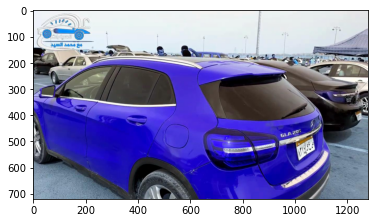

In [107]:
image = r"E:\car plates code\plates-models-master\model8\runs\detect\exp\image0.jpg"
show_image_and_final_result(image)

In [33]:
def perform_object_detection(frame):
    results = detection_model(frame)
    crops = results.crop(save=True)
    return results

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



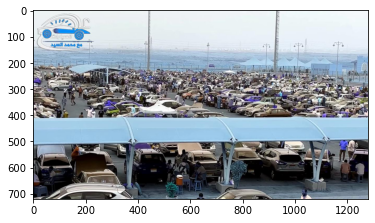

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



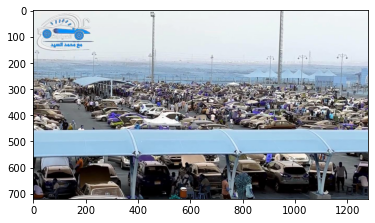

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



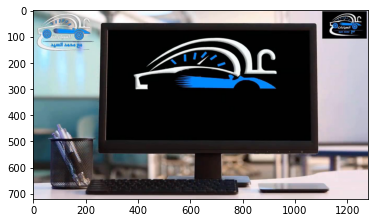

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



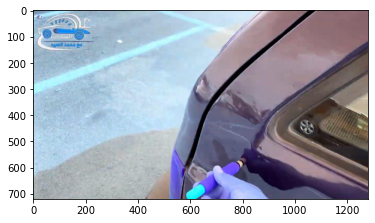

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



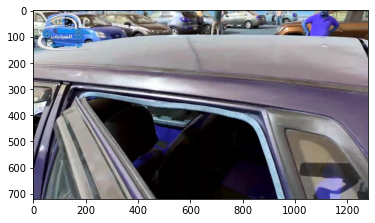

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



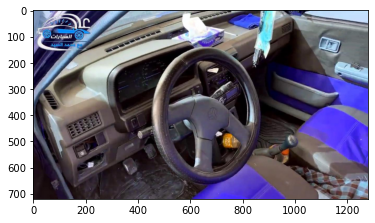

Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



KeyboardInterrupt: 

In [108]:
# Define the path to the input video file
video_path = r"E:\car plates code\plates-models-master\videos\video.mp4"

# Define the output directory for saving the frames
output_dir = r"E:\car plates code\plates-models-master\videos\saved_frames\saved_frames"
os.makedirs(output_dir, exist_ok=True)

# Initialize the video capture object
cap = cv2.VideoCapture(video_path)

# Initialize variables for frame extraction
frame_count = 0
frame_rate = 20  # Extract a frame every second

# Loop through the frames of the video and extract frames at the specified frame rate
while True:
    lst = []
    ret, frame = cap.read()
    if not ret:
        break

    # Check if it's time to extract a frame
    if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:
        # Save the frame as an image in the output directory
        cv2.imwrite(os.path.join(output_dir, f"frame{frame_count}.jpg"), frame)
        delete_folder_or_file(exp_path)    
        delete_folder_or_file(saved_img_dir)
        delete_folder_or_file(resized_img_dir)
        results = perform_object_detection(frame)
#         print(results)
        # accuracy = results.xyxyn[0][:, -2].cpu().numpy()[0]
        # if accuracy > 0.5:
#         crops = results.crop(save=True)
        final_result = return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, resized_img_dir)
        image = r"E:\car plates code\plates-models-master\model8\runs\detect\exp\image0.jpg"
        show_image_and_final_result(image)

    # Increment the frame count
    frame_count += 1

    # Set the video capture object to the next frame at the specified frame rate
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count * frame_rate)

# Release the video capture object
cap.release()

In [ ]:
# Define the output directory for saving the frames
output_dir = r"E:\car plates code\plates-models-master\videos\saved_frames\saved_frames"
os.makedirs(output_dir, exist_ok=True)

# Initialize the video capture object
cap = cv2.VideoCapture(0)

# Initialize variables for frame extraction
frame_count = 0
frame_rate = 5  # Extract a frame every second

# Loop through the frames of the video and extract frames at the specified frame rate
while True:
    lst = []
    ret, frame = cap.read()
    if not ret:
        break

    # Check if it's time to extract a frame
    if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:
        # Save the frame as an image in the output directory
        cv2.imwrite(os.path.join(output_dir, f"frame{frame_count}.jpg"), frame)
        delete_folder_or_file(exp_path)    
        delete_folder_or_file(saved_img_dir)
        delete_folder_or_file(resized_img_dir)
        results = perform_object_detection(frame)
#         print(results)
        # accuracy = results.xyxyn[0][:, -2].cpu().numpy()[0]
        # if accuracy > 0.5:
#         crops = results.crop(save=True)
        final_result = return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, resized_img_dir)
        image = r"E:\car plates code\plates-models-master\model8\runs\detect\exp\image0.jpg"
        show_image_and_final_result(image)

    # Increment the frame count
    frame_count += 1

    # Set the video capture object to the next frame at the specified frame rate
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count * frame_rate)

# Release the video capture object
cap.release()

In [112]:
lst = []
# Define the path to the input video file
video_path = r"E:\car plates code\plates-models-master\videos\video.mp4"


# Define the output directory for saving the frames
output_dir = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\saved_frames3"
os.makedirs(output_dir, exist_ok=True)

# Initialize the video capture object
cap = cv2.VideoCapture(video_path)

# Initialize variables for frame extraction
frame_count = 0
frame_rate = 20  # Extract a frame every second

# Loop through the frames of the video and extract frames at the specified frame rate
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Check if it's time to extract a frame
    if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:
        # Save the frame as an image in the output directory
        cv2.imwrite(os.path.join(output_dir, f"frame{frame_count}.jpg"), frame)
        delete_folder_or_file(exp_path)    
        delete_folder_or_file(saved_img_dir)
        delete_folder_or_file(resized_img_dir)
        results = perform_object_detection(frame)
#         print(results)
        # accuracy = results.xyxyn[0][:, -2].cpu().numpy()[0]
        # if accuracy > 0.5:
#         crops = results.crop(save=True)
        final_result = return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, resized_img_dir)
        if final_result != "2":
            image = r"E:\car plates code\plates-models-master\model8\runs\detect\exp\image0.jpg"
            show_image_and_final_result(image)
            if final_result not in lst:
                lst.append(final_result)
            print(final_result)
        else:
            continue

    # Increment the frame count
    frame_count += 1

    # Set the video capture object to the next frame at the specified frame rate
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count * frame_rate)

# Release the video capture object
cap.release()

In [38]:
#real time code
lst = []

# Define the output directory for saving the frames
output_dir = r"E:\car plates code\plates-models-master\videos\saved_frames\saved_frames"
os.makedirs(output_dir, exist_ok=True)

# Initialize the video capture object for the default camera (index 0)
cap = cv2.VideoCapture(0)

# Initialize variables for frame extraction
frame_count = 0
frame_rate = 10  # Extract a frame every second

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Check if it's time to extract a frame
    if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:
        # Save the frame as an image in the output directory
        cv2.imwrite(os.path.join(output_dir, f"frame{frame_count}.jpg"), frame)

        delete_folder_or_file(exp_path)
        delete_folder_or_file(saved_img_dir)
        delete_folder_or_file(resized_img_dir)
        
        results = perform_object_detection(frame)
        final_result = return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, resized_img_dir)
        
        if final_result != "2":
            image = r"E:\car plates code\plates-models-master\model8\runs\detect\exp\image0.jpg"
            show_image_and_final_result(image)
            if final_result not in lst:
                lst.append(final_result)
            print(final_result)
        else:
            continue

    # Increment the frame countq
    frame_count += 1

    # Set the video capture object to the next frame at the specified frame rate
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count * frame_rate)

# Release the video capture object
cap.release()

In [264]:
lst

[[['ب'], '٩٤٥٩', 'أخرى'],
 [['د', 'ف', 'ب'], '٩٤٥٩', 'الدقهلية'],
 [['ج', 'أ', 'د'], '٤١٣٩', 'أخرى'],
 [['و', 'ع', 'ق'], '٧٩٤٦', 'بني سويف'],
 [[], '', 'أخرى']]

In [247]:
lst

[[['ب'], '٩٤٥٩', 'أخرى'],
 [['د', 'ف', 'ب'], '٩٤٥٩', 'الدقهلية'],
 [['ج', 'أ', 'د'], '٤١٣٩', 'أخرى'],
 [['و', 'ع', 'ق'], '٧٩٤٦', 'بني سويف'],
 [[], '', 'أخرى']]

In [265]:
lst.pop()

[[], '', 'أخرى']

In [266]:
lst

[[['ب'], '٩٤٥٩', 'أخرى'],
 [['د', 'ف', 'ب'], '٩٤٥٩', 'الدقهلية'],
 [['ج', 'أ', 'د'], '٤١٣٩', 'أخرى'],
 [['و', 'ع', 'ق'], '٧٩٤٦', 'بني سويف']]

YOLOv5  2023-9-24 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ب'], '٩٤٥٩', 'أخرى']


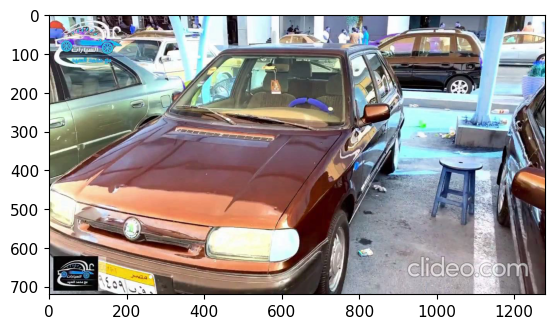

YOLOv5  2023-9-24 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ف', 'ب'], '٩٤٥٩', 'الدقهلية']


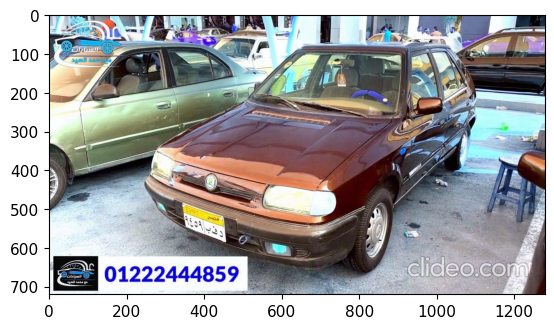

YOLOv5  2023-9-24 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ف', 'ب'], '٩٤٥٩', 'الدقهلية']


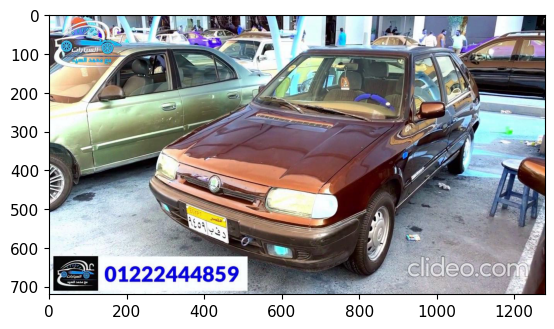

YOLOv5  2023-9-24 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['د', 'ف', 'ب'], '٩٤٥٩', 'الدقهلية']


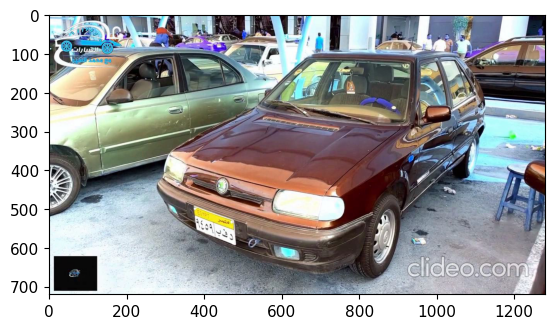

YOLOv5  2023-9-24 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ج', 'أ', 'د'], '٤١٣٩', 'أخرى']


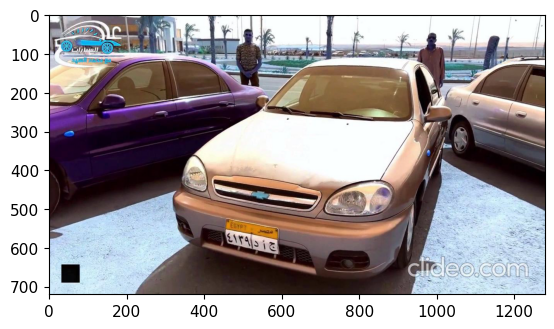

YOLOv5  2023-9-24 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ج', 'أ', 'د'], '٤١٣٩', 'أخرى']


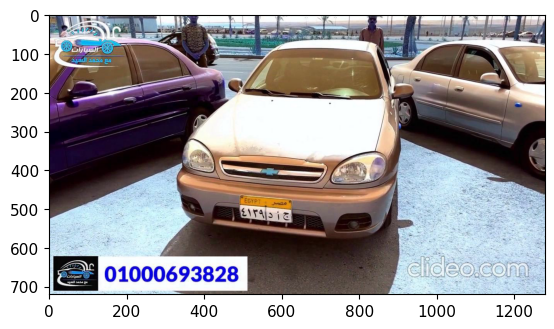

YOLOv5  2023-9-24 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['ج', 'أ', 'د'], '٤١٣٩', 'أخرى']


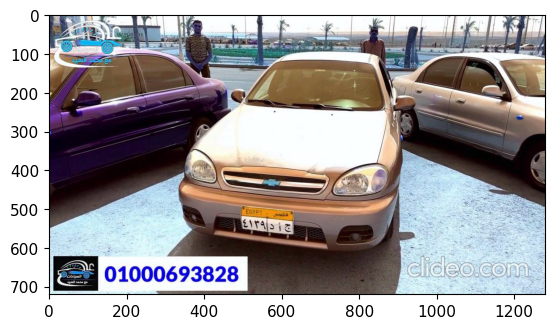

YOLOv5  2023-9-24 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['و', 'ع', 'ق'], '٧٩٤٦', 'بني سويف']


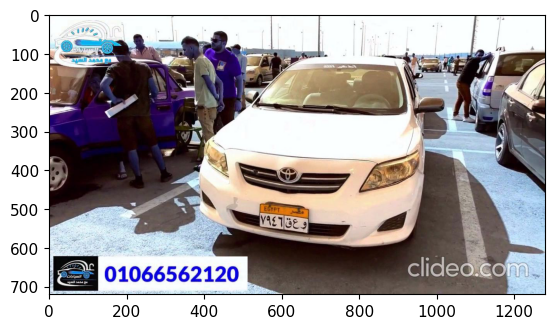

YOLOv5  2023-9-24 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['و', 'ع', 'ق'], '٧٩٤٦', 'بني سويف']


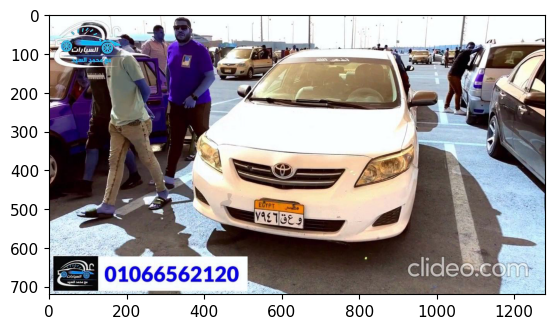

YOLOv5  2023-9-24 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[['و', 'ع', 'ق'], '٧٩٤٦', 'بني سويف']


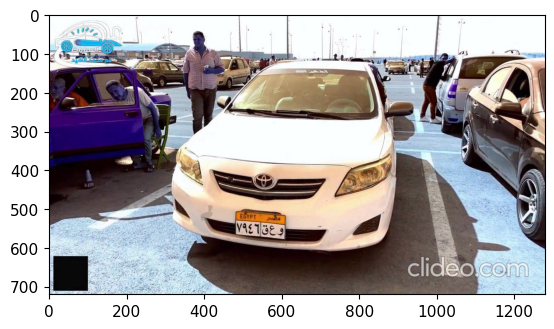

YOLOv5  2023-9-24 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[[], '', 'أخرى']


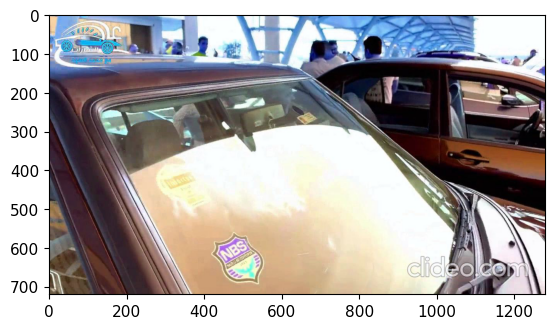

YOLOv5  2023-9-24 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



[[], '', 'أخرى']


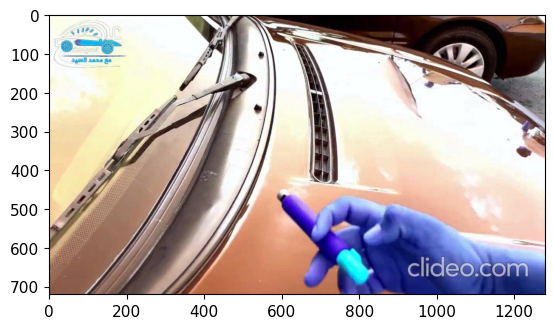

YOLOv5  2023-9-24 Python-3.11.3 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Saved 1 image to runs\detect\exp
Saved results to runs\detect\exp



UnboundLocalError: cannot access local variable 'image_path' where it is not associated with a value

In [222]:
lst = []
# Define the path to the input video file
video_path = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\crop_video\crop\merge2.mp4"

# Define the output directory for saving the frames
output_dir = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\saved_frames3"
os.makedirs(output_dir, exist_ok=True)

# Initialize the video capture object
cap = cv2.VideoCapture(video_path)

# Initialize variables for frame extraction
frame_count = 0
frame_rate = 3  # Extract a frame every second

# Loop through the frames of the video and extract frames at the specified frame rate
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Check if it's time to extract a frame
    if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:
        # Save the frame as an image in the output directory
        cv2.imwrite(os.path.join(output_dir, f"frame{frame_count}.jpg"), frame)
        delete_folder_or_file(exp_path)    
        delete_folder_or_file(saved_img_dir)
        delete_folder_or_file(resized_img_dir)
        results = perform_object_detection(frame)
#         print(results)
        # accuracy = results.xyxyn[0][:, -2].cpu().numpy()[0]
        # if accuracy > 0.5:
#         crops = results.crop(save=True)
        final_result = return_final_result(exp_path, detection_model, images, cropped_img_dir, saved_img_dir, resized_img_dir)
        image = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\image0.jpg"
        show_image_and_final_result(image)
        if final_result not in lst:
            lst.append(final_result)

    # Increment the frame count
    frame_count += 1

    # Set the video capture object to the next frame at the specified frame rate
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count * frame_rate)

# Release the video capture object
cap.release()

In [223]:
lst

[[['ب'], '٩٤٥٩', 'أخرى'],
 [['د', 'ف', 'ب'], '٩٤٥٩', 'الدقهلية'],
 [['ج', 'أ', 'د'], '٤١٣٩', 'أخرى'],
 [['و', 'ع', 'ق'], '٧٩٤٦', 'بني سويف'],
 [[], '', 'أخرى']]

In [230]:
def if_folder_exists():
    folder_path = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp"
    if os.path.exists(folder_path):
        return("1")

In [163]:
lst

[[[], '', 'أخرى'],
 [[], '', 'أخرى'],
 [[], '', 'أخرى'],
 [[], '', 'أخرى'],
 [[], '', 'أخرى'],
 [[], '', 'أخرى'],
 [[], '', 'أخرى'],
 [[], '', 'أخرى'],
 [[], '', 'أخرى'],
 [[], '', 'أخرى'],
 [[], '', 'أخرى']]

In [152]:
def delete_image():
    path = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\crops\car-plate"
    
    if os.path.exists(path):
        for i in os.listdir(path):
            x = i.split(".jpg")[0].split("image")[1]
            if x != '0':
                os.remove(os.path.join(path, i))
                print(f"Deleted: {i}")
        return "success"
    else:
        print(f"Path does not exist: {path}")
        return "error"

def deleted():
    delete_folder_or_file(exp_path)    
    delete_folder_or_file(saved_img_dir)
    delete_folder_or_file(resized_img_dir)
    return    
        
# Function to perform object detection and return final result
def perform_object_detection(frame):
    # Perform object detection on the frame using YOLOv5
    # Example code, replace with your own implementation
#     model_path = r"path/to/yolov5/model.pt"
#     model = torch.hub.load('.', 'custom', path='F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3/best.pt', source='local')
    results = detection_model(frame)
    crops = results.crop(save=True)
    return results

# # Function to process detection results and return final result
# def return_final_result():
#     # Process detection results and return final result
#     # Example code, replace with your own implementation
#     final_result = None
#     return final_result

# Define the path to the input video file
video_path = r"F:/egyptian car plates dataset/EALPR Vechicles dataset/plates models/detection_model/model3/1.mp4"

# Define the output directory for saving the frames
output_dir = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\saved_frames3"
os.makedirs(output_dir, exist_ok=True)

# Initialize the video capture object
cap = cv2.VideoCapture(video_path)

# Initialize variables for frame extraction
frame_count = 0
frame_rate = 1  # Extract a frame every second

# Loop through the frames of the video and extract frames at the specified frame rate
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Check if it's time to extract a frame
    if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:
        # Save the frame as an image in the output directory
        cv2.imwrite(os.path.join(output_dir, f"frame{frame_count}.jpg"), frame)
        
        # Delete other images
        output = delete_image()
        if output != "error":
            # Perform object detection on the frame
            results = perform_object_detection(frame)
            # Process detection results and get the final result
            final_result = return_final_result()
            lst.append(final_result)
            print(lst)
            deleted()
            
#             # Process the bounding boxes, labels, and scores as desired
#             boxes = results.xyxy[0][:, :4].detach().numpy()
#             labels = results.xyxy[0][:, 5].detach().numpy()
#             scores = results.xyxy[0][:, 4].detach().numpy()
        else:
            continue
    
    # Increment the frame count
    frame_count += 1

    # Set the video capture object to the next frame at the specified frame rate
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count * frame_rate)

# Release the video capture object
cap.release()

Path does not exist: F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\crops\car-plate
Path does not exist: F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\crops\car-plate
Path does not exist: F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\crops\car-plate
Path does not exist: F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\crops\car-plate
Path does not exist: F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\crops\car-plate
Path does not exist: F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\crops\car-plate
Path does not exist: F:\egyptian car plates dataset\EALPR Vechicles dataset\plates model

KeyboardInterrupt: 

In [146]:
lst

[]

In [ ]:
        except (OSError, cv2.error) as e:
            print(f"Error processing image {img}: {e}")
            continue

In [63]:
lst[0]

[['ق', 'ع', 'ر'], '١١', 'أخرى']

In [15]:
path = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\crops\car-plate"
for i in os.listdir(path):
    print(path+"\\"+i)

F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\crops\car-plate\image0.jpg
F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\crops\car-plate\image02.jpg


In [16]:
path = r"F:\egyptian car plates dataset\EALPR Vechicles dataset\plates models\detection_model\model3\yolov5\runs\detect\exp\crops\car-plate"
for i in os.listdir(path):
    x = i.split(".jpg")[0].split("image")[1]
    if x != '0':
        os.remove(path+"\\"+i)
        print("Image file deleted successfully.")

Image file deleted successfully.


In [115]:
# Initialize the video capture object for the camera (default camera, index 0)
cap = cv2.VideoCapture(0)

while True:
    # Read a frame from the camera
    ret, frame = cap.read()

    if not ret:
        break

    # Display the frame in a window
    cv2.imshow('Camera Feed', frame)

    # Exit the loop when the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close the window
cap.release()
cv2.destroyAllWindows()

In [119]:
#Create an object to hold reference to camera video capturing
vidcap = cv2.VideoCapture(0)

#check if connection with camera is successfully
if vidcap.isOpened():
    ret, frame = vidcap.read()  #capture a frame from live video

    #check whether frame is successfully captured
    if ret:
        # continue to display window until 'q' is pressed
        while(True):
            cv2.imshow("Frame",frame)   #show captured frame
            
            #press 'q' to break out of the loop
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    #print error if frame capturing was unsuccessful
    else:
        print("Error : Failed to capture frame")

# print error if the connection with camera is unsuccessful
else:
    print("Cannot open camera")
    